# 模型安全

## 概述

本次体验流程介绍MindArmour提供的模型安全防护手段，引导您快速使用MindArmour，为您的AI模型提供一定的安全防护能力。

AI算法设计之初普遍未考虑相关的安全威胁，使得AI算法的判断结果容易被恶意攻击者影响，导致AI系统判断失准。攻击者在原始样本处加入人类不易察觉的微小扰动，导致深度学习模型误判，称为对抗样本攻击。MindArmour模型安全提供对抗样本生成、对抗样本检测、模型防御、攻防效果评估等功能，为AI模型安全研究和AI应用安全提供重要支撑。

- 对抗样本生成模块支持安全工程师快速高效地生成对抗样本，用于攻击AI模型。
- 对抗样本检测、防御模块支持用户检测过滤对抗样本、增强AI模型对于对抗样本的鲁棒性。
- 评估模块提供多种指标全面评估对抗样本攻防性能。

接下来通过图像分类任务上的对抗性攻防，以攻击算法FGSM和防御算法NAD为例，体验MindArmour在对抗攻防上的使用方法。

## 整体流程

1. 准备环节。下载MNIST数据集，配置运行信息和数据处理。
2. 预训练模型。定义LeNet5网络，训练模型，生成CheckPoint文件。
3. 建立被攻击模型。加载预训练模型，测试模型精度，攻击模型，测试攻击后模型精度。
4. 对抗性防御。防御实现和防御效果分析。

> 本次体验流程支持硬件平台为：
> - CPU：在配置运行信息环节配置`context.set_context`中的`device_target`参数为`device_target="CPU"`（本次体验默认使用CPU硬件平台）。
> - GPU：在配置运行信息环节配置`context.set_context`中的`device_target`参数为`device_target="GPU"`。
> - Ascend：在配置运行信息环节配置`context.set_context`中的`device_target`参数为`device_target="Ascend"`。

## 准备环节

###  下载数据集

本次体验使用MNIST数据集，定义函数`download_dataset`下载MNIST数据集到当前工作目录下的`./MNIST_Data/`目录里。或者可以将下载好的训练和测试数据集解压后分别放在当前工作目录下的`./MNIST_Data/train`、`./MNIST_Data/test`路径下。

> MNIST数据集下载地址为：<http://yann.lecun.com/exdb/mnist/>，页面提供4个数据集下载链接，其中前2个文件是训练数据需要，后2个文件是测试结果需要。

In [1]:
import os
import urllib.request
from urllib.parse import urlparse
import gzip


def unzip_file(gzip_path):
    """
    unzip dataset file
    
    Args:
        gzip_path (str): Dataset file path.
    """
    open_file = open(gzip_path.replace('.gz', ''), 'wb')
    gz_file = gzip.GzipFile(gzip_path)
    open_file.write(gz_file.read())
    gz_file.close()

def download_dataset():
    """Download the dataset from http://yann.lecun.com/exdb/mnist/."""
    print("{:*^40}".format("Downloading the MNIST dataset"))
    train_path = "./MNIST_Data/train/"
    test_path = "./MNIST_Data/test/"
    train_path_check = os.path.exists(train_path)
    test_path_check = os.path.exists(test_path)
    if not train_path_check and not test_path_check:
        os.makedirs(train_path)
        os.makedirs(test_path)
    train_url = {"http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz"}
    test_url = {"http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz", "http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz"}
    for url in train_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(train_path, url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz', '')):
            urllib.request.urlretrieve(url, file_name)
            unzip_file(file_name)
            os.remove(file_name)
    for url in test_url:
        url_parse = urlparse(url)
        # split the file name from url
        file_name = os.path.join(test_path, url_parse.path.split('/')[-1])
        if not os.path.exists(file_name.replace('.gz', '')):
            urllib.request.urlretrieve(url, file_name)
            unzip_file(file_name)
            os.remove(file_name)
    print("\n{:*^40}".format("Downloaded"))

download_dataset()

*****Downloading the MNIST dataset******

***************Downloaded***************


MNIST数据集下载完成后，此时当前工作目录下`MNIST`目录结构为：

```shell
MNIST_Data
├── test
│   ├── t10k-images-idx3-ubyte
│   └── t10k-labels-idx1-ubyte
└── train
    ├── train-images-idx3-ubyte
    └── train-labels-idx1-ubyte
```

- 其中：
    - `t10k-images-idx3-ubyte`为测试图像数据文件。
    - `t10k-labels-idx1-ubyte`为测试图像标签文件。
    - `train-images-idx3-ubyte`为训练图像数据文件。
    - `train-labels-idx1-ubyte`为训练图像标签文件。

### 配置运行信息


运行以下一段代码配置运行环境。其中：
- `device_target`：指定运行环境，本次体验流程基于CPU环境，配置`device_target="CPU"`。
- `set_level`：指定LOGGER输出等级，此处配置为`LOGGER.set_level(1)`。


In [2]:
from mindspore import context
from mindarmour.utils.logger import LogUtil


context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
LOGGER = LogUtil.get_instance()
LOGGER.set_level(1)

### 数据处理

利用MindSpore的`dataset`模块提供的`MnistDataset`接口加载MNIST数据集，定义函数`generate_mnist_dataset`对原始数据进行预处理操作，以创建可用于训练和测试的数据集。利用数据加载函数`generate_mnist_dataset`载入数据生成训练数据集`ds_train`和测试数据集`ds_test`。

In [3]:
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as CV
import mindspore.dataset.transforms.c_transforms as C
from mindspore.dataset.vision import Inter
from mindspore.common import dtype as mstype


# generate testing data
def generate_mnist_dataset(data_path, batch_size=32, repeat_size=1,
                           num_parallel_workers=1, sparse=True):
    """
    create dataset for training or testing
    """
    # define dataset
    ds1 = ds.MnistDataset(data_path)

    # define operation parameters
    resize_height, resize_width = 32, 32
    rescale = 1.0 / 255.0
    shift = 0.0

    # define map operations
    resize_op = CV.Resize((resize_height, resize_width),
                          interpolation=Inter.LINEAR)
    rescale_op = CV.Rescale(rescale, shift)
    hwc2chw_op = CV.HWC2CHW()
    type_cast_op = C.TypeCast(mstype.int32)

    # apply map operations on images
    if not sparse:
        one_hot_enco = C.OneHot(10)
        ds1 = ds1.map(operations=one_hot_enco, input_columns="label",
                      num_parallel_workers=num_parallel_workers)
        type_cast_op = C.TypeCast(mstype.float32)
    ds1 = ds1.map(operations=type_cast_op, input_columns="label",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=resize_op, input_columns="image",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=rescale_op,input_columns="image",
                  num_parallel_workers=num_parallel_workers)
    ds1 = ds1.map(operations=hwc2chw_op, input_columns="image",
                  num_parallel_workers=num_parallel_workers)

    # apply DatasetOps
    buffer_size = 10000
    ds1 = ds1.shuffle(buffer_size=buffer_size)
    ds1 = ds1.batch(batch_size, drop_remainder=True)
    ds1 = ds1.repeat(repeat_size)

    return ds1

batch_size = 32
ds_train = generate_mnist_dataset("./MNIST_Data/train/")
ds_test = generate_mnist_dataset("./MNIST_Data/test/", batch_size=batch_size, sparse=False)

&emsp;&emsp;运行以下一段代码，打印数据集`ds_train`第一组共32张训练图像信息。

The 32 images with label of the first batch in ds_train are showed below:


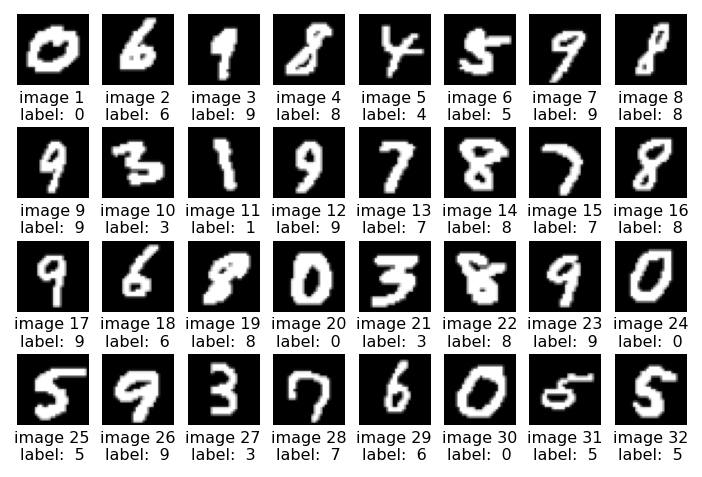

In [4]:
from matplotlib import pyplot as plt
import numpy as np

print("The 32 images with label of the first batch in ds_train are showed below:")
ds_iterator = ds_train.create_dict_iterator()
ds_iterator.get_next()
batch_1 = ds_iterator.get_next()
batch_image = batch_1["image"].asnumpy()
batch_label = batch_1["label"].asnumpy()
%matplotlib inline
plt.figure(dpi=144)
for i,image in enumerate(batch_image):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = np.squeeze(image, 0)
    image = image/np.amax(image)
    image = np.clip(image, 0, 1)
    plt.imshow(image, cmap="gray")
    plt.title(f"image {i+1}\nlabel:  {batch_label[i]}", y=-0.65, fontdict={"fontsize":8})
    plt.axis('off')    
plt.show()

## 预训练模型

### 定义网络

本次流程以LeNet5模型为例，您也可以建立训练自己的模型。运行以下一段代码，定义LeNet5网络模型。

In [5]:
import mindspore.nn as nn
from mindspore.common.initializer import TruncatedNormal


def conv(in_channels, out_channels, kernel_size, stride=1, padding=0):
    weight = weight_variable()
    return nn.Conv2d(in_channels, out_channels,
                     kernel_size=kernel_size, stride=stride, padding=padding,
                     weight_init=weight, has_bias=False, pad_mode="valid")


def fc_with_initialize(input_channels, out_channels):
    weight = weight_variable()
    bias = weight_variable()
    return nn.Dense(input_channels, out_channels, weight, bias)


def weight_variable():
    return TruncatedNormal(0.02)


class LeNet5(nn.Cell):
    """
    Lenet network
    """
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = conv(1, 6, 5)
        self.conv2 = conv(6, 16, 5)
        self.fc1 = fc_with_initialize(16*5*5, 120)
        self.fc2 = fc_with_initialize(120, 84)
        self.fc3 = fc_with_initialize(84, 10)
        self.relu = nn.ReLU()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()

    def construct(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

### 训练模型

运行以下一段代码，训练模型并保存CheckPoint文件。

In [6]:
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor
from mindspore.train import Model
from mindspore.nn.metrics import Accuracy


lr = 0.01
momentum = 0.9
network = LeNet5()
net_loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction="mean")
net_opt = nn.Momentum(network.trainable_params(), lr, momentum)
time_cb = TimeMonitor(data_size=ds_train.get_dataset_size())
config_ck = CheckpointConfig(save_checkpoint_steps=1875,
                             keep_checkpoint_max=10)
ckpoint_cb = ModelCheckpoint(prefix="checkpoint_lenet", config=config_ck)
model = Model(network, net_loss, net_opt, metrics={"Accuracy": Accuracy()})

print("============== Starting Training ==============")
model.train(epoch=10, train_dataset=ds_train, callbacks=[time_cb, ckpoint_cb, LossMonitor()],
                dataset_sink_mode=False)

============== Starting Training ==============
epoch: 1 step: 1, loss is 2.2966673
epoch: 1 step: 2, loss is 2.3142211
epoch: 1 step: 3, loss is 2.3002968
epoch: 1 step: 4, loss is 2.2986352
epoch: 1 step: 5, loss is 2.3062992
epoch: 1 step: 6, loss is 2.3027751
epoch: 1 step: 7, loss is 2.3007572
epoch: 1 step: 8, loss is 2.3042161
epoch: 1 step: 9, loss is 2.2996876
epoch: 1 step: 10, loss is 2.3026795

...

epoch: 10 step: 1865, loss is 0.051650025
epoch: 10 step: 1866, loss is 0.004669161
epoch: 10 step: 1867, loss is 0.00537819
epoch: 10 step: 1868, loss is 0.0038884382
epoch: 10 step: 1869, loss is 0.05690967
epoch: 10 step: 1870, loss is 0.08228033
epoch: 10 step: 1871, loss is 0.00020364714
epoch: 10 step: 1872, loss is 0.065785594
epoch: 10 step: 1873, loss is 0.028175712
epoch: 10 step: 1874, loss is 0.00413411
epoch: 10 step: 1875, loss is 0.007664079
Epoch time: 28778.540, per step time: 15.349


## 建立被攻击模型

以MNIST为示范数据集，自定义的简单模型LeNet5网络模型作为被攻击模型。

### 加载LeNet模型文件

运行以下一段代码，加载预训练的LeNet模型文件（`checkpoint_lenet-10_1875.ckpt`）。

In [7]:
from mindspore import load_checkpoint, load_param_into_net


ckpt_name = './checkpoint_lenet-10_1875.ckpt'
net = LeNet5()
load_dict = load_checkpoint(ckpt_name)
load_param_into_net(net, load_dict)

### 测试攻击前模型精度

从训练数据集`ds_test`中抽取前3组共96张数据图像和标签用于测试预训练模型精度。运行以下一段代码，测试预训练模型对被攻击之前的测试图像进行预测的精度。通过输出INFO信息可以看到，测试结果中分类精度达到了97.9%。

In [8]:
from mindspore import Tensor


# prediction accuracy before attack
TAG = 'demo'
model = Model(net)
batch_num = 3  # the number of batches of attacking samples
test_images = []
test_labels = []
predict_labels = []
i = 0
for data in ds_test.create_tuple_iterator():
    i += 1
    images = data[0].asnumpy().astype(np.float32)
    labels = data[1].asnumpy()
    test_images.append(images)
    test_labels.append(labels)
    pred_labels = np.argmax(model.predict(Tensor(images)).asnumpy(),
                            axis=1)
    predict_labels.append(pred_labels)
    if i >= batch_num:
        break
predict_labels = np.concatenate(predict_labels)
true_labels = np.argmax(np.concatenate(test_labels), axis=1)
accuracy = np.mean(np.equal(predict_labels, true_labels))
LOGGER.info(TAG, "prediction accuracy before attacking is : %s", accuracy)

[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:24,108 [<ipython-input-8-5a5e4376f509>:26] [demo] prediction accuracy before attacking is : 0.9791666666666666


运行以下一段代码，打印测试数据图像信息。

Test images before attacking showed below:



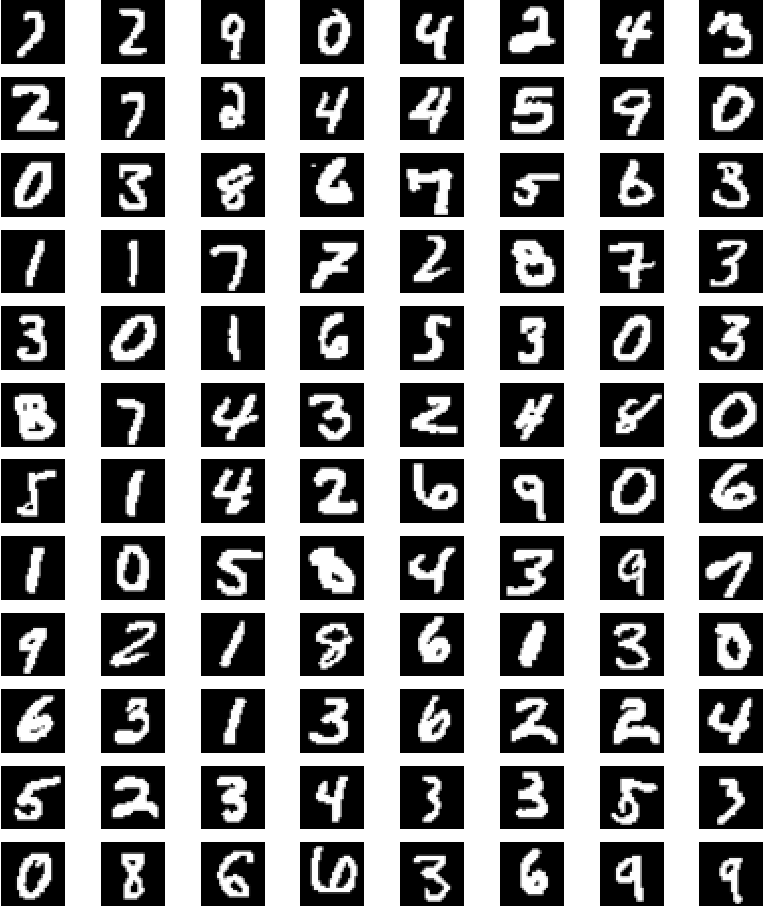

In [9]:
%matplotlib inline
plt.figure(figsize=(100.0, 120.0), dpi=10)
for j,images in enumerate(test_images):
    for i,image in enumerate(images):
        plt.subplot(12, 8, i+1+32*j)
        plt.subplots_adjust(wspace=0.3)
        image = np.squeeze(image, 0)
        image = image/np.amax(image)
        image = np.clip(image, 0, 1)
        plt.imshow(image, cmap='gray', interpolation='nearest')
        # plt.title(f"image {i+1}\nlabel:  {batch_label[i]}", y=-0.65, fontdict={"fontsize":8})
        plt.axis('off')   
print("Test images before attacking showed below:\n")
plt.show()

### 攻击模型

调用MindArmour提供的FGSM接口（`FastGradientSignMethod`），使用被攻击前抽取的96张数据图像`test_images`作为被攻击数据集，保存被攻击后数据集图像到当前notebook目录下的`ada_data`文件中。其中，参数`eps`为攻击对数据范围产生的单步对抗性摄动的比例，该值越大，则攻击程度越大。关于`FastGradientSignMethod`的详细使用说明，可参考[官方API文档](https://www.mindspore.cn/doc/api_python/zh-CN/master/mindarmour/mindarmour.adv_robustness.attacks.html#mindarmour.adv_robustness.attacks.FastGradientSignMethod)。

In [10]:
import time
from mindarmour.adv_robustness.attacks import FastGradientSignMethod


# attacking
attack = FastGradientSignMethod(net, eps=0.3)
start_time = time.perf_counter()
adv_data = attack.batch_generate(np.concatenate(test_images),
                                 np.concatenate(test_labels), batch_size=32)
stop_time = time.perf_counter()
np.save('./adv_data', adv_data)

### 测试攻击后模型精度

对模型进行FGSM无目标攻击后，通过输出信息可以看到：

模型精度由97.9%降到19.8%，误分类率高达80%，成功攻击的对抗样本的预测类别的平均置信度（ACAC）为 0.73765075，成功攻击的对抗样本的真实类别的平均置信度（ACTC）为 0.041447524，同时给出了生成的对抗样本与原始样本的零范数距离、二范数距离和无穷范数距离，平均每个对抗样本与原始样本间的结构相似性为0.33272708，平均每生成一张对抗样本所需时间为0.001377s。

In [11]:
from scipy.special import softmax
from mindarmour.adv_robustness.evaluations import AttackEvaluate


pred_logits_adv = model.predict(Tensor(adv_data)).asnumpy()
# rescale predict confidences into (0, 1).
pred_logits_adv = softmax(pred_logits_adv, axis=1)
pred_labels_adv = np.argmax(pred_logits_adv, axis=1)
accuracy_adv = np.mean(np.equal(pred_labels_adv, true_labels))
LOGGER.info(TAG, "prediction accuracy after attacking is : %s", accuracy_adv)
attack_evaluate = AttackEvaluate(np.concatenate(test_images).transpose(0, 2, 3, 1),
                                 np.concatenate(test_labels),
                                 adv_data.transpose(0, 2, 3, 1),
                                 pred_logits_adv)

LOGGER.info(TAG, 'mis-classification rate of adversaries is : %s',
            attack_evaluate.mis_classification_rate())
LOGGER.info(TAG, 'The average confidence of adversarial class is : %s',
            attack_evaluate.avg_conf_adv_class())
LOGGER.info(TAG, 'The average confidence of true class is : %s',
            attack_evaluate.avg_conf_true_class())
LOGGER.info(TAG, 'The average distance (l0, l2, linf) between original '
            'samples and adversarial samples are: %s',
            attack_evaluate.avg_lp_distance())
LOGGER.info(TAG, 'The average structural similarity between original '
            'samples and adversarial samples are: %s',
            attack_evaluate.avg_ssim())
LOGGER.info(TAG, 'The average costing time is %s',
            (stop_time - start_time)/(batch_num*batch_size))

[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:29,568 [<ipython-input-11-7db9d04380f1>:10] [demo] prediction accuracy after attacking is : 0.19791666666666666
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:29,573 [<ipython-input-11-7db9d04380f1>:17] [demo] mis-classification rate of adversaries is : 0.8020833333333334
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:29,575 [<ipython-input-11-7db9d04380f1>:19] [demo] The average confidence of adversarial class is : 0.73765075
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:29,576 [<ipython-input-11-7db9d04380f1>:21] [demo] The average confidence of true class is : 0.041447524
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:29,583 [<ipython-input-11-7db9d04380f1>:24] [demo] The average distance (l0, l2, linf) between original samples and adversarial samples are: (1.6081334162994763, 0.45166983136190164, 0.3000000374657734)
[INFO] MA(23555:139900077446976,MainProcess):

打印被攻击后的测试图像信息，由输出图像结果可以看出，被攻击后的图像和攻击前相比，成功误导了模型，使模型将其误分类为其他非正确类别。

Test images after attacking showed below:



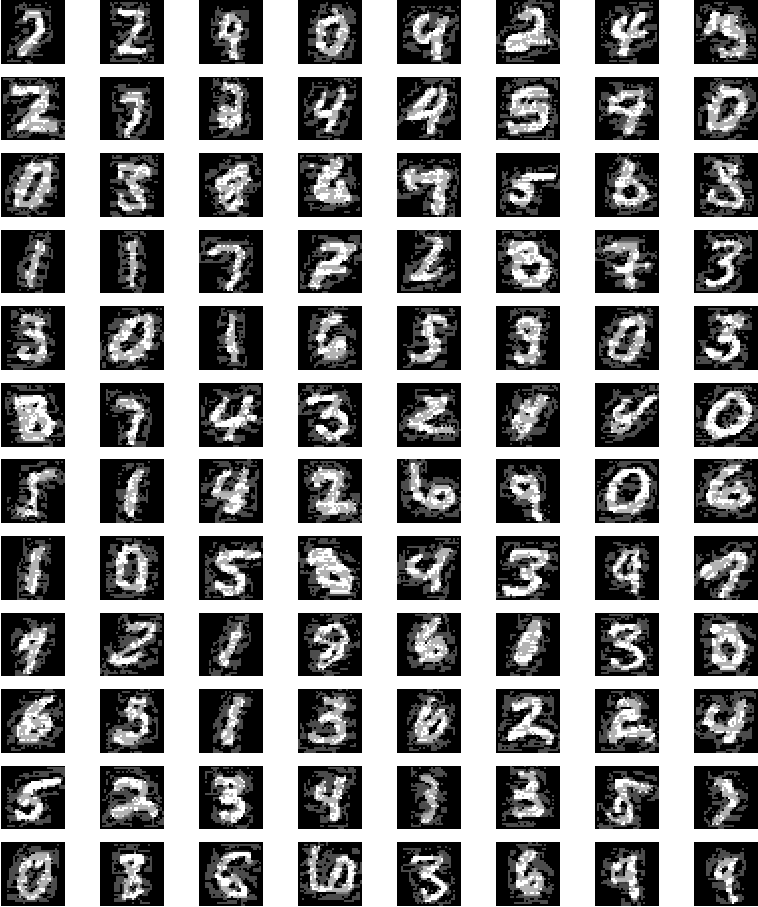

In [12]:
%matplotlib inline
plt.figure(figsize=(100.0, 120.0), dpi=10)
plt.set_cmap('binary')
for i,image in enumerate(adv_data):
    plt.subplot(12, 8, i+1)
    # plt.subplots_adjust(wspace=0.2, hspace=0.2)
    image = np.squeeze(image, 0)
    image = image/np.amax(image)
    image = np.clip(image, 0, 1)
    plt.imshow(image, cmap='gray', interpolation='nearest')
    plt.axis('off')   
print("Test images after attacking showed below:\n")
plt.show()

## 对抗性防御

`NaturalAdversarialDefense`（NAD）是一种简单有效的对抗样本防御方法，使用对抗训练的方式，在模型训练的过程中构建对抗样本，并将对抗样本与原始样本混合，一起训练模型。随着训练次数的增加，模型在训练的过程中提升对于对抗样本的鲁棒性。NAD算法使用FGSM作为攻击算法，构建对抗样本。

### 防御实现

调用MindArmour提供的NAD防御接口（`NaturalAdversarialDefense`）。

In [13]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits
from mindarmour.adv_robustness.defenses import NaturalAdversarialDefense


loss = SoftmaxCrossEntropyWithLogits(sparse=False, reduction='mean')
opt = nn.Momentum(net.trainable_params(), 0.01, 0.09)

nad = NaturalAdversarialDefense(net, loss_fn=loss, optimizer=opt,
                                bounds=(0.0, 1.0), eps=0.3)
net.set_train()
nad.batch_defense(np.concatenate(test_images), np.concatenate(test_labels),
                  batch_size=32, epochs=20)

# get accuracy of test data on defensed model
net.set_train(False)
acc_list = []
pred_logits_adv = []
for i in range(batch_num):
    batch_inputs = test_images[i]
    batch_labels = test_labels[i]
    logits = net(Tensor(batch_inputs)).asnumpy()
    pred_logits_adv.append(logits)
    label_pred = np.argmax(logits, axis=1)
    acc_list.append(np.mean(np.argmax(batch_labels, axis=1) == label_pred))
pred_logits_adv = np.concatenate(pred_logits_adv)
pred_logits_adv = softmax(pred_logits_adv, axis=1)

LOGGER.info(TAG, 'accuracy of TEST data on defensed model is : %s',
             np.mean(acc_list))
acc_list = []
for i in range(batch_num):
    batch_inputs = adv_data[i * batch_size: (i + 1) * batch_size]
    batch_labels = test_labels[i]
    logits = net(Tensor(batch_inputs)).asnumpy()
    label_pred = np.argmax(logits, axis=1)
    acc_list.append(np.mean(np.argmax(batch_labels, axis=1) == label_pred))

attack_evaluate = AttackEvaluate(np.concatenate(test_images),
                                 np.concatenate(test_labels),
                                 adv_data,
                                 pred_logits_adv)

LOGGER.info(TAG, 'accuracy of adv data on defensed model is : %s',
            np.mean(acc_list))
LOGGER.info(TAG, 'defense mis-classification rate of adversaries is : %s',
            attack_evaluate.mis_classification_rate())
LOGGER.info(TAG, 'The average confidence of adversarial class is : %s',
            attack_evaluate.avg_conf_adv_class())
LOGGER.info(TAG, 'The average confidence of true class is : %s',
            attack_evaluate.avg_conf_true_class())
LOGGER.info(TAG, 'The average distance (l0, l2, linf) between original '
            'samples and adversarial samples are: %s',
            attack_evaluate.avg_lp_distance())


[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:35,859 [<ipython-input-13-f8a913e8fc63>:29] [demo] accuracy of TEST data on defensed model is : 1.0
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:35,876 [<ipython-input-13-f8a913e8fc63>:44] [demo] accuracy of adv data on defensed model is : 0.875
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:35,878 [<ipython-input-13-f8a913e8fc63>:46] [demo] defense mis-classification rate of adversaries is : 0.0
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:35,880 [<ipython-input-13-f8a913e8fc63>:48] [demo] The average confidence of adversarial class is : 0
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:35,881 [<ipython-input-13-f8a913e8fc63>:50] [demo] The average confidence of true class is : 0
[INFO] MA(23555:139900077446976,MainProcess):2020-08-08 14:51:35,883 [<ipython-input-13-f8a913e8fc63>:53] [demo] The average distance (l0, l2, linf) between original samples and adversa

### 防御效果

通过输出信息可以看出，使用NAD进行对抗样本防御后，模型对于对抗样本的误分类率从80%降至12.5%，模型有效地防御了对抗样本。同时，模型对于原来测试数据集的分类精度达100%，使用NAD防御功能，并未降低模型的分类精度。

## 总结

以上便完成了MindArmour在模型安全上的应用体验，我们通过本次体验理解了对模型攻击的概念和原理，了解了如何使用`FastGradientSignMethod`接口对模型攻击和`NaturalAdversarialDefense`接口实现对抗性防御。